# Solution

In [ ]:
!pip install igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import igraph
import time
from tqdm.auto import tqdm


In [ ]:
from igraph import *
import json
import random
import numpy as np
from numpy import linalg
import itertools
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay  # needed for triangulation
import os
import pandas as pd
import networkx as nx
from matplotlib.collections import LineCollection
from multiprocessing import Pool
from copy import deepcopy

In [ ]:
random.seed(2022)
np.random.seed(2022)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import files

Mounted at /content/drive


In [ ]:
with open('/content/drive/My Drive/ECE 232E/los_angeles_censustracts.json') as f:
    census_tracts = json.loads(f.readline())

In [ ]:
census_tracts['features'][0]['properties']

{'MOVEMENT_ID': '1', 'TRACT': '480302', 'DISPLAY_NAME': 'Census Tract 480302'}

In [ ]:
np.array(census_tracts['features'][0]['geometry']['coordinates'][0]).mean(axis=0)  # [longitude, latitude]

array([-118.12053321,   34.10309557])

In [ ]:
display_names = dict()
coordinates = dict()

for area in census_tracts['features']:
    id = int(area['properties']['MOVEMENT_ID'])
    display_name = area['properties']['DISPLAY_NAME']
    display_names[id] = display_name
    a = area['geometry']['coordinates'][0]
    coordinates[id] = np.array(a if type(a[0][0]) == float else a[0]).mean(axis=0)

In [ ]:
for i in range(5):
    key = i + 1
    print('{}: {}, {}'.format(key, display_names[key], coordinates[key]))

1: Census Tract 480302, [-118.12053321   34.10309557]
2: Census Tract 480303, [-118.13785063   34.09645121]
3: Census Tract 480304, [-118.13138209   34.09626386]
4: Census Tract 480400, [-118.13224544   34.10349303]
5: Census Tract 480500, [-118.14492317   34.0986815 ]


In [ ]:
g = Graph(directed=False)
g.add_vertices(len(display_names))
g.vs['display_name'] = list(display_names.values())  # index = id - 1
g.vs['coordinates'] = list(coordinates.values())

In [ ]:
month_filter = {12}  # for monthly aggregate data of 4th quarter, we can filter data based off of only December

edges = []
weights = []

with open('/content/drive/My Drive/ECE 232E/Project 4/los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv') as f:
    f.readline()  # skip the first line

    while True:
        line = f.readline()
        if line == '':
            break  # end of file

        vals = line.strip().split(',')

        # read edge info
        src, dest, month, dist = int(vals[0]), int(vals[1]), int(vals[2]), float(vals[3])

        # if data is not relevant, skip it
        if month not in month_filter:
            continue

        edges.append((src - 1, dest - 1))
        weights.append(dist)

In [ ]:
g.add_edges(edges)
g.es['weight'] = weights
del edges, weights

In [ ]:
print(len(g.vs), len(g.es))

2716 1692450


In [ ]:
# keep only the giant connected component
components = g.components()
gcc = max(components, key=len)
vs_to_delete = [i for i in range(len(g.vs)) if i not in gcc]
g.delete_vertices(vs_to_delete)

# remove duplicate edges
g = g.simplify(combine_edges=dict(weight='mean'))  # combine duplicate edges

In [ ]:
print(len(g.vs), len(g.es))

2649 1003858


In [ ]:
print(g.vs[0])
print(g.vs[1])


igraph.Vertex(<igraph.Graph object at 0x7ff320708a40>, 0, {'display_name': 'Census Tract 480302', 'coordinates': array([-118.12053321,   34.10309557])})
igraph.Vertex(<igraph.Graph object at 0x7ff320708a40>, 1, {'display_name': 'Census Tract 480303', 'coordinates': array([-118.13785063,   34.09645121])})


In [ ]:
mst = g.spanning_tree(weights=g.es['weight'])

In [ ]:
for edge in mst.get_edgelist()[:5]:
    print("Edge: {} -> {}".format(g.vs['coordinates'][edge[0]], g.vs['coordinates'][edge[1]]))

Edge: [-118.12053321   34.10309557] -> [-118.13138209   34.09626386]
Edge: [-118.12053321   34.10309557] -> [-118.11656383   34.09585388]
Edge: [-118.13785063   34.09645121] -> [-118.13138209   34.09626386]
Edge: [-118.13785063   34.09645121] -> [-118.13224544   34.10349303]
Edge: [-118.13785063   34.09645121] -> [-118.14184446   34.08538654]


In [ ]:
edf = mst.get_edge_dataframe()
edf.head()

source  target   weight
edge ID                         
0             0       2  129.765
1             0      13  118.335
2             1       2   90.235
3             1       3  126.475
4             1       9  125.675

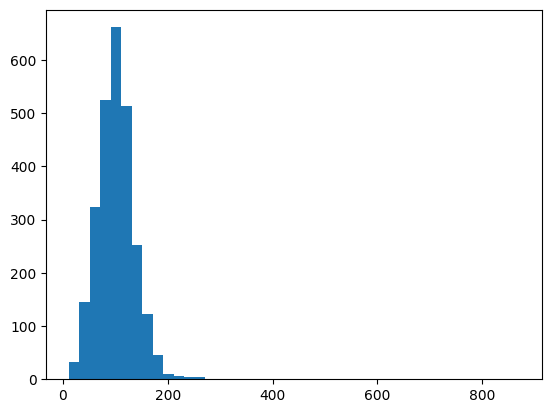

In [ ]:
import matplotlib.pyplot as plt
weights = mst.es['weight']
binwidth = 20
bins = np.arange(min(weights), max(weights) + binwidth, binwidth)
plt.hist(weights, bins=bins)
plt.show()

In [ ]:
for i, e in enumerate(mst.es):
    print('Distance in miles: {:.3f}\nTime taken: {:.1f}\n---------\n'.format(linalg.norm(mst.vs[e.source]['coordinates'] - mst.vs[e.target]['coordinates'])* 69, e['weight']))
    if i > 10:
        break

Distance in miles: 0.885
Time taken: 129.8
---------

Distance in miles: 0.570
Time taken: 118.3
---------

Distance in miles: 0.447
Time taken: 90.2
---------

Distance in miles: 0.621
Time taken: 126.5
---------

Distance in miles: 0.812
Time taken: 125.7
---------

Distance in miles: 0.618
Time taken: 119.9
---------

Distance in miles: 0.936
Time taken: 125.2
---------

Distance in miles: 0.412
Time taken: 91.8
---------

Distance in miles: 0.256
Time taken: 60.9
---------

Distance in miles: 0.204
Time taken: 87.1
---------

Distance in miles: 0.620
Time taken: 110.9
---------

Distance in miles: 0.493
Time taken: 162.3
---------



# TSP Approximation

### Check Traingle Inequality

In [ ]:
def is_triangle(sides):
    #write code here

  sides.sort()
  return sides[0] + sides[1] > sides[2]

print('Test:', is_triangle([1,4,2]), is_triangle([3,5,3]))

Test: False True


In [ ]:
def sample_triangles(g, n_samples):
  result = []
  count = 0

  while count < n_samples:

      a_tri = []
      for i in range(0,3):
        a_tri.append(random.randint(0,len(g.vs()) -1))
      check = 0
      for i in range(3):
        for j in range(i):
          if g.es.select(_between=([a_tri[i]], [a_tri[j]]))['weight'] ==[]:
            check = 1
            break
      if check == 0:
        count  = count + 1
        result.append(tuple(a_tri))
  return result

In [ ]:
n_samples = 1000  # WARNING: this might take a minute for larger sample sizes
triangles = 0
sampled = sample_triangles(g, n_samples)

c  = 0

for triangle_vs in sampled:

  edge_lengths = []

  for i in range(3):
    for j in range(i):

        x = g.es.select(_between=([triangle_vs[i]], [triangle_vs[j]]))['weight']

        print(x)
        if x == []:
          continue
        else:

          edge_lengths.append(min(x))

  if len(edge_lengths) == 3:
    c = c + 1
    triangles += is_triangle(edge_lengths)

print(len(sampled))
print(c)
print('Triangle inequality holds by {}%'.format(round(100.0 * triangles / n_samples, 1)))

[730.53]
[1942.37]
[1680.9650000000001]
[1757.525]
[994.21]
[1521.1750000000002]
[1523.825]
[2301.88]
[2093.595]
[1882.29]
[1670.87]
[344.2]
[634.9200000000001]
[1694.25]
[2357.29]
[654.27]
[677.895]
[572.54]
[1174.885]
[1684.37]
[1834.78]
[1995.89]
[2670.25]
[1770.73]
[1125.24]
[799.845]
[789.47]
[2045.28]
[1330.33]
[1932.35]
[369.095]
[1263.83]
[767.645]
[1204.94]
[1202.16]
[152.22500000000002]
[1266.505]
[1984.67]
[943.3199999999999]
[1560.23]
[1466.39]
[1360.97]
[1971.87]
[968.44]
[1857.87]
[1440.5]
[2153.285]
[1904.33]
[693.64]
[926.45]
[1061.12]
[1537.36]
[2019.625]
[1240.63]
[1120.525]
[870.37]
[1337.775]
[1468.565]
[1228.0700000000002]
[2295.845]
[2345.77]
[2372.24]
[733.105]
[2675.5]
[2194.61]
[2045.55]
[1212.6799999999998]
[1811.625]
[1210.89]
[578.2349999999999]
[719.53]
[1331.585]
[1953.05]
[753.08]
[1551.51]
[57.290000000000006]
[1698.91]
[1761.67]
[1977.425]
[1735.2649999999999]
[745.975]
[1539.83]
[871.655]
[697.275]
[1982.68]
[2085.43]
[1976.6]
[706.14]
[651.28500000000

### Preorder Traversal Demo

In [ ]:
def preorder_traversal(root, root_parent=None):
    result = [root]
    for v in root.neighbors():
        if v == root_parent:
            continue
        result.extend(preorder_traversal(v, root))
    return result


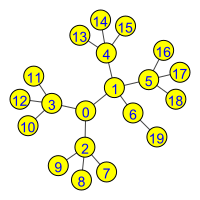

In [ ]:
t = Graph.Tree(20, 3)

visual_style = {}
visual_style["vertex_color"] = 'yellow'
visual_style["vertex_label"] = [v.index for v in t.vs]
visual_style["vertex_label_color"] = 'blue'
visual_style["bbox"] = (200, 200)

plot(t, **visual_style)

In [ ]:
print([v.index for v in preorder_traversal(t.vs[0])])

[0, 1, 4, 13, 14, 15, 5, 16, 17, 18, 6, 19, 2, 7, 8, 9, 3, 10, 11, 12]


### Actual Data

In [ ]:
mst = g.spanning_tree(weights=g.es["weight"])
tsp = preorder_traversal(mst.vs[0])


print('IDs:\n' + '-' * 10 + '\n' + '\n'.join([mst.vs[i.index]['display_name'] for i in tsp]))


IDs:
----------
Census Tract 480302
Census Tract 480304
Census Tract 480303
Census Tract 480400
Census Tract 480500
Census Tract 480804
Census Tract 480704
Census Tract 480704
Census Tract 480703
Census Tract 201120
Census Tract 201501
Census Tract 201503
Census Tract 201401
Census Tract 201200
Census Tract 201110
Census Tract 201301
Census Tract 199110
Census Tract 199120
Census Tract 199202
Census Tract 199201
Census Tract 199800
Census Tract 201504
Census Tract 480704
Census Tract 480500
Census Tract 480703
Census Tract 480702
Census Tract 183702
Census Tract 183103
Census Tract 183104
Census Tract 183101
Census Tract 183220
Census Tract 183221
Census Tract 183222
Census Tract 181500
Census Tract 183620
Census Tract 183610
Census Tract 480600
Census Tract 183104
Census Tract 463900
Census Tract 464000
Census Tract 183702
Census Tract 183701
Census Tract 183820
Census Tract 183810
Census Tract 183520
Census Tract 183510
Census Tract 186203
Census Tract 185100
Census Tract 199400
Cens

In [ ]:
hop_distances = []
for i in range(len(tsp) - 1):
    if g.are_connected(tsp[i], tsp[i+1]):
        hop_distances.append(g.es[g.get_eid(tsp[i], tsp[i+1])]["weight"])
hop_distances.append(g.es[g.get_eid(tsp[-1], tsp[0])]["weight"]) if g.are_connected(tsp[-1], tsp[0]) else 0  # Add the distance between the last node and the first node if exists

print('Hop distances:\n' + '-' * 10 + '\n' +
      '\n'.join(['{:.3f}'.format(x) for x in hop_distances]))

Hop distances:
----------
129.765
90.235
126.475
125.160
91.785
60.910
87.115
43.330
68.810
130.045
117.430
97.520
88.940
121.045
219.300
122.560
101.975
185.285
116.045
96.300
613.815
485.570
127.635
243.310
115.820
91.310
58.075
63.395
114.085
104.440
109.100
77.220
87.820
338.830
100.195
428.130
140.670
78.305
175.055
380.025
68.525
82.645
108.085
110.405
84.215
98.150
157.270
71.385
92.435
82.635
91.390
84.445
241.260
146.690
179.660
568.025
121.495
397.170
84.635
243.805
83.080
73.635
61.540
60.360
45.455
53.030
67.820
52.470
44.020
94.160
78.885
70.305
101.305
97.930
112.880
133.095
135.995
115.225
129.880
101.210
115.790
143.455
235.365
79.545
57.410
78.845
61.860
55.235
60.085
44.215
91.140
120.360
156.935
154.350
140.325
135.730
235.970
131.585
109.775
381.465
99.745
130.065
179.295
190.030
157.105
131.875
129.210
114.380
138.635
128.245
327.830
129.410
373.715
127.630
470.780
129.195
380.145
103.385
87.600
128.645
113.630
110.490
99.990
146.310
348.865
134.685
142.590
1042.80

### Measureing Relative Performance Guarantee

In [ ]:
mst_cost = sum(mst.es['weight'])

<hr><b><font color="red">WARNING: SLOW!</font></b>

In [ ]:
tsp_cost = 0
for i in range(len(tsp) - 1):
    if g.are_connected(tsp[i], tsp[i+1]):
        tsp_cost += g.es[g.get_eid(tsp[i], tsp[i+1])]["weight"]
    else:
        print(f"No edge between nodes {tsp[i]} and {tsp[i+1]}.")

if g.are_connected(tsp[-1], tsp[0]):
    tsp_cost += g.es[g.get_eid(tsp[-1], tsp[0])]["weight"]
else:
    print(f"No edge between nodes {tsp[-1]} and {tsp[0]}.")

In [ ]:
print('MST Cost:', round(mst_cost))
print('TSP Cost:', round(tsp_cost))
print('Ratio:', round(tsp_cost/mst_cost, 2))

MST Cost: 269085
TSP Cost: 438552
Ratio: 1.63


---
TSP results should resemble the following figure

In [ ]:
all_coordinates = np.array(g.vs['coordinates'])
tsp_coordinates = all_coordinates[tsp, :]
tsp_coordinates = np.vstack([tsp_coordinates, tsp_coordinates[0, :]])  # connect the last element back to the first element

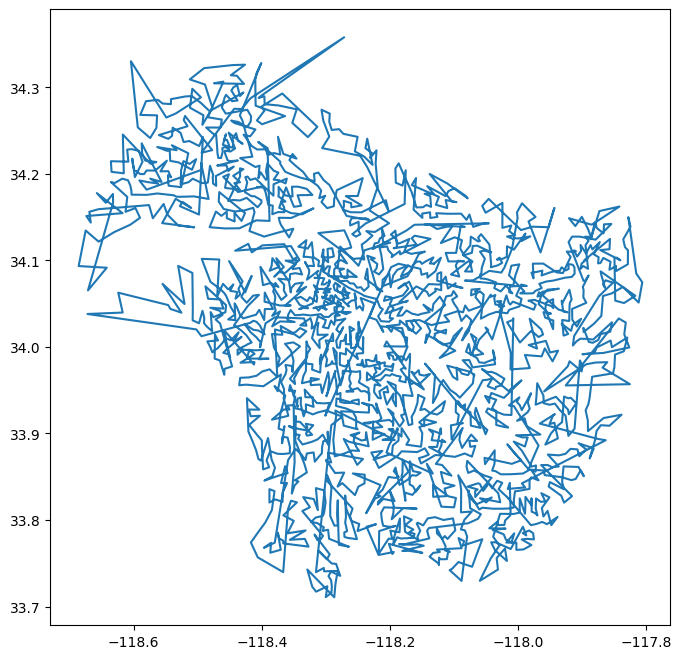

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(tsp_coordinates[:, 0], tsp_coordinates[:, 1],'-')
plt.show()

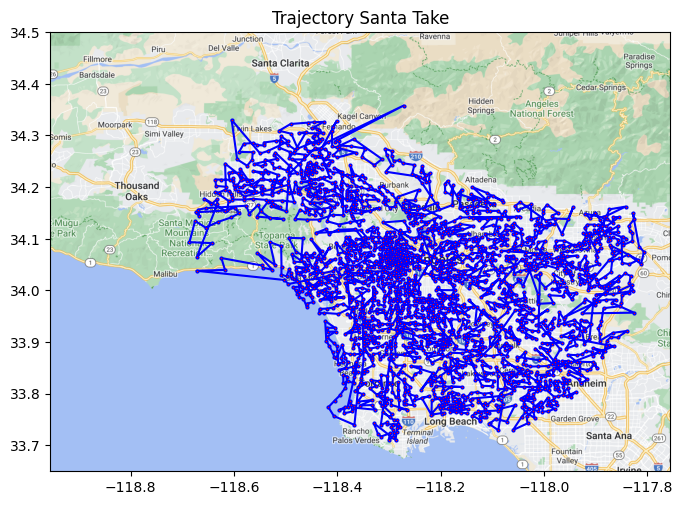

In [ ]:
Bound = ((-118.955, -117.755, 33.65, 34.5))
la_map = plt.imread('/content/drive/My Drive/ECE 232E/la.jpg')
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(tsp_coordinates[:, 0], tsp_coordinates[:, 1], color="blue", marker="o", markersize=2, markerfacecolor="red")
ax.set_title("Trajectory Santa Take")
ax.set_xlim(Bound[0], Bound[1])
ax.set_ylim(Bound[2], Bound[3])
ax.imshow(la_map, zorder=0, extent=Bound, aspect="equal")
plt.show()

### Triangulation

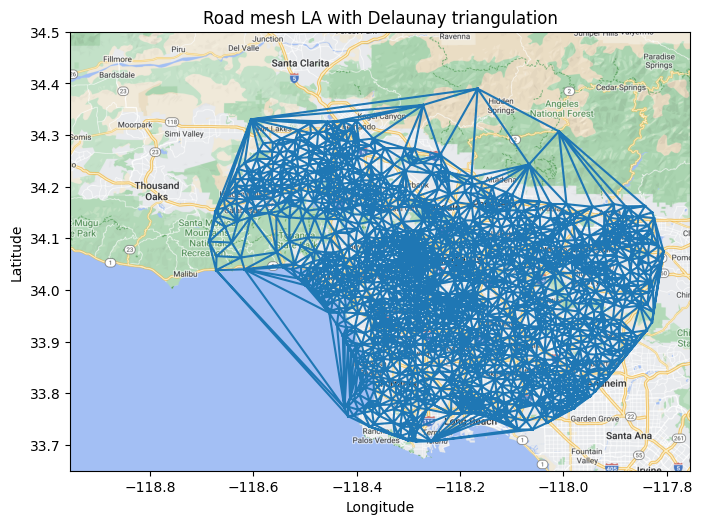

In [ ]:
with open('/content/drive/My Drive/ECE 232E/Project 4/los_angeles_censustracts.json', 'r') as f:
    data = json.load(f)
    features = data['features']

lat_long = {}
for feature in features:
    geometry = feature['geometry']
    properties = feature['properties']
    coordinates = np.array(geometry['coordinates'][0]) if geometry['type'] == 'Polygon' else np.array(geometry['coordinates'][0][0])
    latitude = np.mean(coordinates[:, 1])
    longitude = np.mean(coordinates[:, 0])
    lat_long[properties['MOVEMENT_ID']] = (properties['DISPLAY_NAME'], latitude, longitude)

lat = [lat for _, lat, _ in lat_long.values()]
lng = [lon for _, _, lon in lat_long.values()]

triangulation = Delaunay(np.column_stack((lng, lat)))

BBox = (-118.955, -117.755, 33.65, 34.5)
image_path = '/content/drive/My Drive/ECE 232E/la.jpg'
image = plt.imread(image_path)

fig, ax = plt.subplots(figsize=(8, 7))
ax.set_xlim(BBox[0], BBox[1])
ax.set_ylim(BBox[2], BBox[3])
ax.set_title('Road mesh LA with Delaunay triangulation')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.imshow(image, zorder=0, extent=BBox, aspect='equal')
ax.triplot(lng, lat, triangulation.simplices)
plt.show()


In [ ]:
lat=[]
lon=[]
for i in range(1,len(lat_long)+1):
    lat.append(lat_long[str(i)][1])
    lon.append(lat_long[str(i)][2])
lat_lon = tuple(zip(lat, lon))
delaunay_out = Delaunay(lat_lon)

g_del=igraph.Graph()
g_del.add_vertices(len(delaunay_out.points))
remove_duplicates=set()
for i in range(len(delaunay_out.simplices)):
    a=((delaunay_out.simplices[i][0], delaunay_out.simplices[i][1]))
    b=((delaunay_out.simplices[i][0], delaunay_out.simplices[i][2]))
    c=((delaunay_out.simplices[i][1], delaunay_out.simplices[i][2]))
    list(a).sort()
    list(b).sort()
    list(c).sort()
    if not a in remove_duplicates:
        remove_duplicates.add(a)
        g_del.add_edges([a])
    if not b in remove_duplicates:
        remove_duplicates.add(b)
        g_del.add_edges([b])
    if not c in remove_duplicates:
        remove_duplicates.add(c)
        g_del.add_edges([c])

malibu= [34.026, -118.78]
long_beach =  [33.77, -118.18]
vcar=(69*np.sqrt((malibu[0]-long_beach[0])**2+(malibu[1]-long_beach[1])**2))/1.05
max_car_num=(3600*vcar)/(5.4 + vcar)

min_long_beach=np.inf
min_malibu=np.inf
long_beach_node=0
malibu_node=0
for i in range(1,len(lat_lon)):
    long_beach_closest=np.sqrt(((lat_lon[i][0])-long_beach[0])**2+((lat_lon[i][1])-long_beach[1])**2)
    malibu_closest=np.sqrt((malibu[0]-lat_lon[i][0])**2+(malibu[1]-lat_lon[i][1])**2)
    if long_beach_closest<min_long_beach:
        min_long_beach=long_beach_closest
        long_beach_node=i
    if malibu_closest<min_malibu:
        min_malibu=malibu_closest
        malibu_node=i

print('Number of edge disjoint paths: ',g_del.adhesion(long_beach_node,malibu_node)-1)


Number of edge disjoint paths:  6


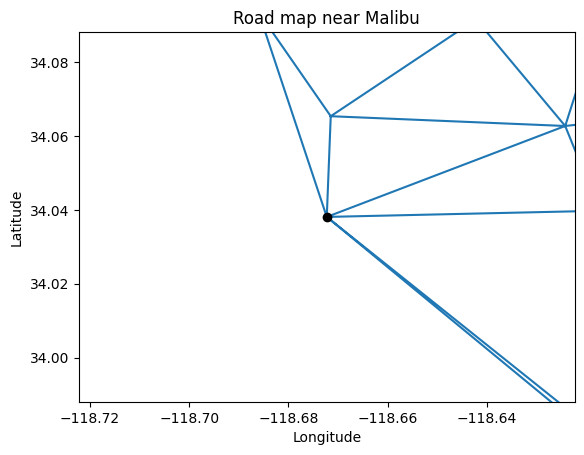

In [ ]:
plt.triplot(lon, lat, delaunay_out.simplices)
plt.ylim(lat_lon[malibu_node][0]-0.05,lat_lon[malibu_node][0]+0.05)
plt.xlim(lat_lon[malibu_node][1]-0.05,lat_lon[malibu_node][1]+0.05)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Malibu')
plt.plot(lon[malibu_node], lat[malibu_node],'o',color='black')
plt.show()

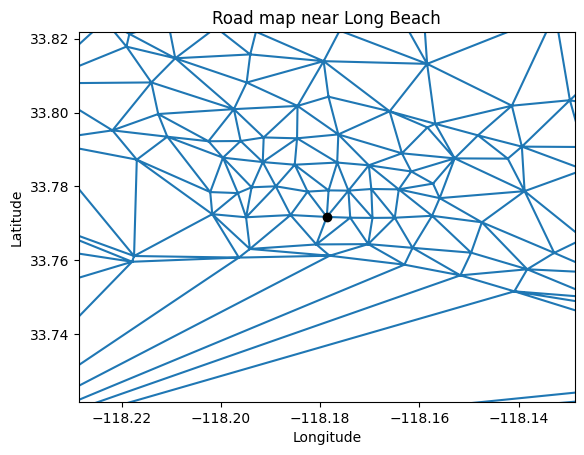

In [ ]:
plt.triplot(lon, lat, delaunay_out.simplices)
plt.ylim(lat_lon[long_beach_node][0]-0.05,lat_lon[long_beach_node][0]+0.05)
plt.xlim(lat_lon[long_beach_node][1]-0.05,lat_lon[long_beach_node][1]+0.05)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Long Beach')
plt.plot(lon[long_beach_node], lat[long_beach_node],'o',color='black')
plt.show()

In [ ]:
#17 prune
g_del_prune = igraph.Graph()
g_del_prune.add_vertices(len(delaunay_out.points))
nodes = g_del_prune.vs()
for i, node in enumerate(nodes):
    node['latitude'] = lat[i]
    node['longitude'] = lon[i]

threshold = (19.2 / 230)

duplicate_remove = set()
edge_cut = set()

def calculate_distance(node1, node2):
    return np.sqrt((node1['latitude'] - node2['latitude'])**2 + (node1['longitude'] - node2['longitude'])**2)

for simplex in delaunay_out.simplices:
    a = tuple(sorted((simplex[0], simplex[1])))
    b = tuple(sorted((simplex[0], simplex[2])))
    c = tuple(sorted((simplex[1], simplex[2])))

    if a not in duplicate_remove:
        duplicate_remove.add(a)
        a_dist_check = calculate_distance(nodes[a[0]], nodes[a[1]])
        if a_dist_check < threshold:
            g_del_prune.add_edges([a])
        else:
            edge_cut.add(a)

    if b not in duplicate_remove:
        duplicate_remove.add(b)
        b_dist_check = calculate_distance(nodes[b[0]], nodes[b[1]])
        if b_dist_check < threshold:
            g_del_prune.add_edges([b])
        else:
            edge_cut.add(b)

    if c not in duplicate_remove:
        duplicate_remove.add(c)
        c_dist_check = calculate_distance(nodes[c[0]], nodes[c[1]])
        if c_dist_check < threshold:
            g_del_prune.add_edges([c])
        else:
            edge_cut.add(c)

edge_cut_list = list(edge_cut)
simplices_list = []

for simplex in delaunay_out.simplices:
    for edge in edge_cut_list:
        if edge[0] in simplex and edge[1] in simplex:
            simplices_list.append(list(simplex))

new_delaunay_out_desimplices = [simplex for simplex in delaunay_out.simplices if list(simplex) not in simplices_list]


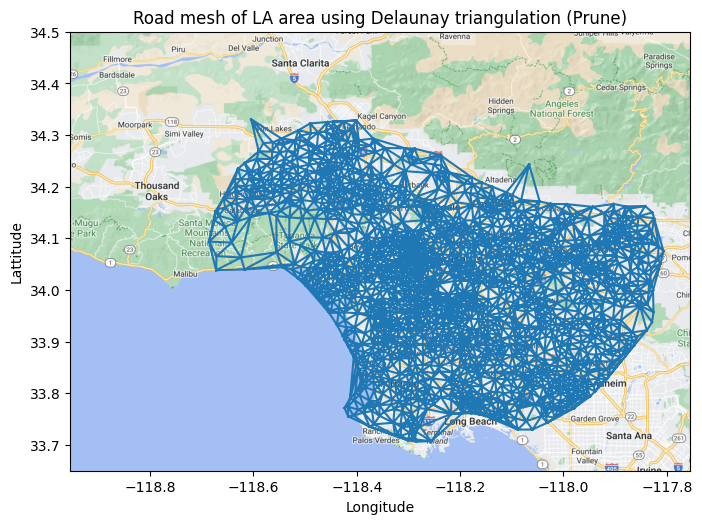

In [ ]:
Bound = (-118.955, -117.755, 33.65, 34.5)

ruh_m = plt.imread('/content/drive/My Drive/ECE 232E/la.jpg')

fig, ax = plt.subplots(figsize = (8,7))
plt.triplot(lon, lat, new_delaunay_out_desimplices)
ax.set_title('Road mesh of LA area using Delaunay triangulation (Prune)')
plt.xlabel('Longitude')
plt.ylabel('Lattitude')
ax.set_xlim(Bound[0],Bound[1])
ax.set_ylim(Bound[2],Bound[3])
ax.imshow(ruh_m, zorder=0, extent = Bound, aspect= 'equal')
plt.show()

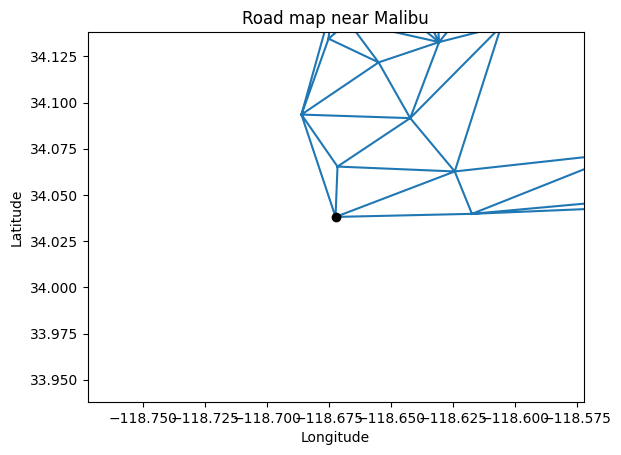

In [ ]:
plt.triplot(lon, lat, new_delaunay_out_desimplices)
plt.ylim(lat_lon[malibu_node][0]-0.1,lat_lon[malibu_node][0]+0.1)
plt.xlim(lat_lon[malibu_node][1]-0.1,lat_lon[malibu_node][1]+0.1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Malibu')
plt.plot(lon[malibu_node], lat[malibu_node],'o',color='black')
plt.show()

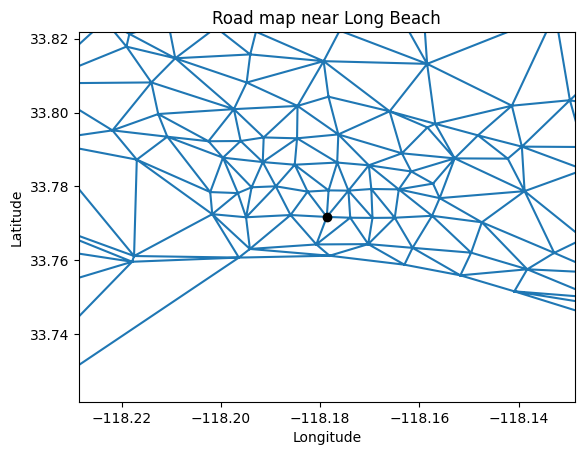

In [ ]:
plt.triplot(lon, lat, new_delaunay_out_desimplices)
plt.ylim(lat_lon[long_beach_node][0]-0.05,lat_lon[long_beach_node][0]+0.05)
plt.xlim(lat_lon[long_beach_node][1]-0.05,lat_lon[long_beach_node][1]+0.05)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Long Beach')
plt.plot(lon[long_beach_node], lat[long_beach_node],'o',color='black')
plt.show()


Q19::


In [ ]:
from itertools import combinations

def sort_additional_distances(graph):
    converted_graph = graph.to_networkx()
    edge_attributes = {(edge.source, edge.target): {"weight": calculate_individual_edge_distance(edge.source, edge.target)}
                       for edge in tqdm(graph.es())}
    nx.set_edge_attributes(converted_graph, edge_attributes)
    shortest_path_lengths = all_pairs_shortest_path_length(converted_graph)
    total_nodes = len(converted_graph)
    infinite_value = 1e6
    additional_distances = [((shortest_path_lengths[node].get(connected_node, infinite_value) -
                             calculate_individual_edge_distance(node, connected_node)), node, connected_node)
                            for node, connected_node in combinations(range(total_nodes), 2)]
    return sorted(additional_distances, key=lambda x: x[0], reverse=True)


In [ ]:
def calculate_individual_edge_distance(source, target):
    longitude_1, longitude_2 = lng[source], lng[target]
    latitude_1, latitude_2 = lat[source], lat[target]
    return compute_distance(longitude_1, longitude_2, latitude_1, latitude_2)

def compute_distance(longitude_1, longitude_2, latitude_1, latitude_2):
    return ((longitude_1 - longitude_2) ** 2 + (latitude_1 - latitude_2) ** 2) ** 0.5


In [ ]:
def display_edge_coordinates(edge_array):
    [print(f"\nedge {index+1}: ({lng[source]}, {lat[source]}) - ({lng[target]}, {lat[target]})")
     for index, (_, source, target) in enumerate(edge_array)]


In [ ]:
def compute_single_source_shortest_path_length(graph, node):
    path_length = nx.single_source_dijkstra_path_length(graph, node)
    return_tuple = (node, path_length)
    return return_tuple


q19:

In [ ]:
k = 20
extra_d = sort_additional_distances(g_del_prune)
extra_d_topk = extra_d[:k]
print("Top 20 pairs with highest extra distance:")
print(extra_d_topk)
display_edge_coordinates(extra_d_topk)


  0%|          | 0/8066 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

Top 20 pairs with highest extra distance: (distance, v, s)
[(999999.9139368199, 2472, 2474), (999999.913911511, 1695, 2473), (999999.9091603315, 706, 2473), (999999.9089513269, 697, 2473), (999999.8995365085, 696, 2473), (999999.8982654467, 707, 2473), (999999.8978336466, 382, 2473), (999999.8935445814, 699, 2473), (999999.8911834201, 698, 2473), (999999.8899602315, 2470, 2473), (999999.8886033287, 708, 2473), (999999.8884314899, 700, 2473), (999999.8883359034, 710, 2473), (999999.8836005878, 2144, 2473), (999999.8830681486, 341, 2473), (999999.8829504105, 701, 2473), (999999.8816231877, 2143, 2473), (999999.8774372394, 2159, 2473), (999999.8721808434, 709, 2473), (999999.8715089136, 705, 2473)]

edge 1: (-118.06647650215331, 34.24297495004306) - (-118.00882743874644, 34.30687687852888)

edge 2: (-118.28809007499999, 34.2733324) - (-118.2715898179769, 34.357824822485206)

edge 3: (-118.3069377237569, 34.2741446519337) - (-118.2715898179769, 34.357824822485206)

edge 4: (-118.2940960822

In [ ]:
cur_graph = g_del_prune.copy()
for _, x, y in tqdm(extra_d_topk):
    cur_graph.add_edges([(x, y)])
ed_new = sort_additional_distances(cur_graph)
print("The highest extra distance after adding new edges:")
print(ed_new[0])


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/8086 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

The highest extra distance after adding new edges: (distance, v, s)
(0.3383265364782666, 2470, 2474)


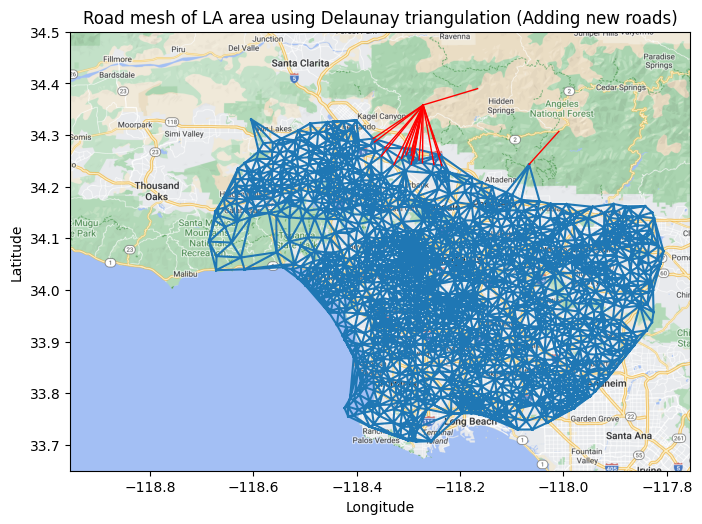

In [ ]:
for distance, v, s in extra_d_topk:
    g_del_prune.add_edge(v, s)

Bound = (-118.955, -117.755, 33.65, 34.5)
ruh_m = plt.imread('/content/drive/My Drive/ECE 232E/la.jpg')

fig, ax = plt.subplots(figsize=(8, 7))
plt.triplot(lon, lat, new_delaunay_out_desimplices)
ax.set_title('Road mesh of LA area using Delaunay triangulation (Adding new roads)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.set_xlim(Bound[0], Bound[1])
ax.set_ylim(Bound[2], Bound[3])
ax.imshow(ruh_m, zorder=0, extent=Bound, aspect='equal')

# Plot the added edges in a different color
for edge in extra_d_topk:
    v, s = edge[1], edge[2]
    x = [lon[v], lon[s]]
    y = [lat[v], lat[s]]
    ax.plot(x, y, color='red', linewidth=1)

plt.show()

Strategy 1 (geodistance_static)

Strategy 2 (geo_distance, static, with_frequency)

In [ ]:
wed = [
    (extra_distance*random.randint(1, 1000), i, j)
    for extra_distance, i, j in tqdm(extra_d)
]
wed_topk = sorted(wed, reverse=True)[:k]
print("Top 20 pairs with highest weighted extra distance:")
print(wed_topk)
display_edge_coordinates(wed_topk)


  0%|          | 0/3686970 [00:00<?, ?it/s]

Top 20 pairs with highest weighted extra distance: (distance, v, s)
[(999999828.4266512, 726, 2473), (999999751.6720145, 312, 2474), (999999647.1049489, 1203, 2470), (999999639.00663, 918, 2470), (999999599.4756286, 2152, 2473), (999999568.7761763, 1433, 2474), (999999460.1719911, 573, 2470), (998999753.638857, 234, 2474), (998999677.2891372, 1751, 2474), (998999585.8890742, 2365, 2474), (998999542.2276021, 1553, 2470), (998999490.9924508, 1610, 2474), (998999460.597362, 626, 2474), (998999389.8422526, 2473, 2528), (997999776.5475531, 2144, 2470), (997999690.9792535, 2176, 2474), (997999690.925722, 1011, 2473), (997999681.628757, 2023, 2473), (997999676.2543713, 788, 2473), (997999668.8754381, 1165, 2474)]

edge 1: (-118.4168469, 34.2665133) - (-118.2715898179769, 34.357824822485206)

edge 2: (-118.03553834375, 34.059989625) - (-118.00882743874644, 34.30687687852888)

edge 3: (-118.19966358333335, 34.03817975) - (-118.16620295644891, 34.38948489307649)

edge 4: (-118.47187526666669, 34

In [ ]:
cur_graph = g_del_prune.copy()
for distance, x, y in tqdm(wed_topk):
    cur_graph.add_edge(x, y)

wed_new = sort_additional_distances(cur_graph)

print("The highest extra distance after adding new edges:")
print(wed_new[0])


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/8106 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

The highest extra distance after adding new edges: (distance, v, s)
(0.3383265364782666, 2470, 2474)


'cur_graph = g_del_prune.copy()\nfor _, x, y in tqdm(weighted_extra_distances_topk):\n    cur_graph.add_edges([(x, y)])\nweighted_extra_distances_with_new_edges = get_sorted_extra_distances(cur_graph)\n\nprint("The highest extra distance after adding new edges: (distance, v, s)")\nprint(weighted_extra_distances_with_new_edges[0])'

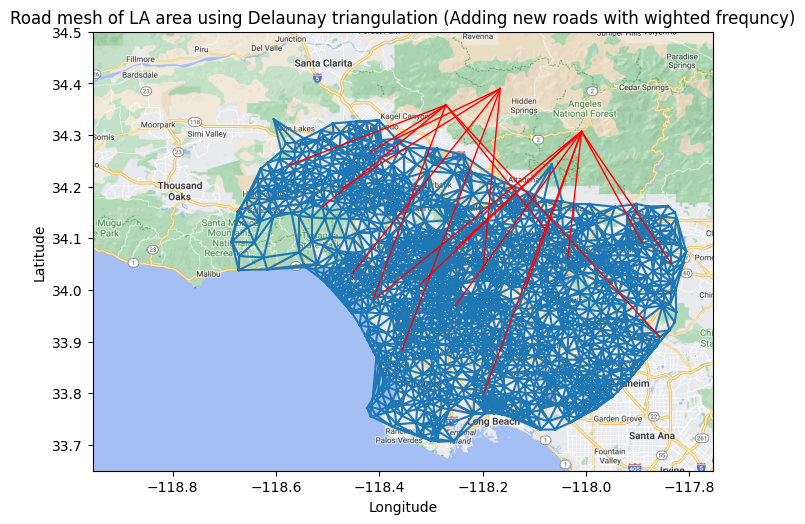

In [ ]:
for distance, v, s in wed_topk:
    g_del_prune.add_edge(v, s)

Bound = (-118.955, -117.755, 33.65, 34.5)
ruh_m = plt.imread('/content/drive/My Drive/ECE 232E/la.jpg')

fig, ax = plt.subplots(figsize=(8, 7))
plt.triplot(lon, lat, new_delaunay_out_desimplices)
ax.set_title('Road mesh of LA area using Delaunay triangulation (Adding new roads with wighted frequncy)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.set_xlim(Bound[0], Bound[1])
ax.set_ylim(Bound[2], Bound[3])
ax.imshow(ruh_m, zorder=0, extent=Bound, aspect='equal')

# Plot the added edges in a different color
for edge in wed_topk:
    v, s = edge[1], edge[2]
    x = [lon[v], lon[s]]
    y = [lat[v], lat[s]]
    ax.plot(x, y, color='red', linewidth=1)

plt.show()

Stategy 3 : (geo_distance, Dynamic)

In [ ]:
cur_graph = g_del_prune.copy()
extra_d_topk_d = []

for _ in tqdm(range(k)):
    max_extra_d = sort_additional_distances(cur_graph)[0]
    extra_d_topk_d.append(max_extra_d)
    cur_graph.add_edges([(max_extra_d[1], max_extra_d[2])])

print("Top 20 pairs with highest extra distance (dynamic):")
print(extra_d_topk_d)
display_edge_coordinates(extra_d_topk_d)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/8106 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

  0%|          | 0/8107 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

  0%|          | 0/8108 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

  0%|          | 0/8109 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

  0%|          | 0/8110 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

  0%|          | 0/8111 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

  0%|          | 0/8112 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

  0%|          | 0/8113 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

  0%|          | 0/8114 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

  0%|          | 0/8115 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

  0%|          | 0/8116 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

  0%|          | 0/8117 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

  0%|          | 0/8118 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

  0%|          | 0/8119 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

  0%|          | 0/8120 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

  0%|          | 0/8121 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

  0%|          | 0/8122 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

  0%|          | 0/8123 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

  0%|          | 0/8124 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

  0%|          | 0/8125 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

Top 20 pairs with highest extra distance (dynamic): (distance, v, s)
[(0.3383265364782666, 2470, 2474), (0.13875329341970616, 2267, 2470), (0.12908474717815344, 56, 2474), (0.09122957293246586, 1710, 2448), (0.08657198086860152, 2470, 2472), (0.07937590455061555, 513, 2470), (0.07929904418128966, 2252, 2474), (0.07416750949415357, 697, 2474), (0.07043194857836443, 433, 2447), (0.07033948562890052, 145, 2447), (0.06988333427152321, 1711, 2448), (0.06952959526013103, 382, 2474), (0.06512478670220112, 2466, 2622), (0.06480680051646553, 382, 2470), (0.06292059717065035, 2466, 2657), (0.06181043785438928, 145, 2398), (0.06152178308385453, 145, 2046), (0.06101710423069995, 433, 2501), (0.060842563208930334, 2465, 2704), (0.06075797070871469, 147, 2548)]

edge 1: (-118.16620295644891, 34.38948489307649) - (-118.00882743874644, 34.30687687852888)

edge 2: (-118.13817560000001, 34.19991316666667) - (-118.16620295644891, 34.38948489307649)

edge 3: (-117.90283844444444, 34.16626599999999) - (-11

In [ ]:
max_e_d = sort_additional_distances(cur_graph)[0]

print("The highest extra distance after adding new edges:")
print(max_e_d)

  0%|          | 0/8126 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

The highest extra distance after adding new edges: (distance, v, s)
(0.06041598008183657, 2464, 2704)


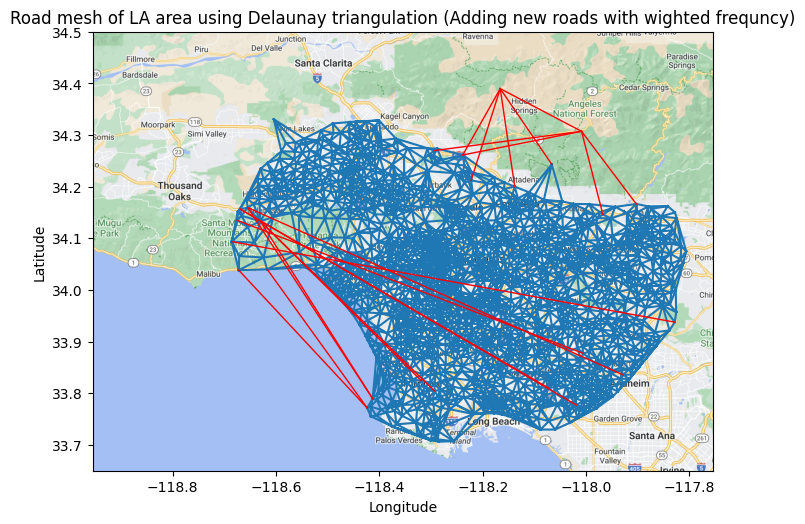

In [ ]:
for distance, v, s in extra_d_topk_dynamic:
    g_del_prune.add_edge(v, s)

Bound = (-118.955, -117.755, 33.65, 34.5)
ruh_m = plt.imread('/content/drive/My Drive/ECE 232E/la.jpg')

fig, ax = plt.subplots(figsize=(8, 7))
plt.triplot(lon, lat, new_delaunay_out_desimplices)
ax.set_title('Road mesh of LA area using Delaunay triangulation (Adding new roads with wighted frequncy)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.set_xlim(Bound[0], Bound[1])
ax.set_ylim(Bound[2], Bound[3])
ax.imshow(ruh_m, zorder=0, extent=Bound, aspect='equal')

# Plot the added edges in a different color
for edge in extra_d_topk_dynamic:
    v, s = edge[1], edge[2]
    x = [lon[v], lon[s]]
    y = [lat[v], lat[s]]
    ax.plot(x, y, color='red', linewidth=1)

plt.show()

strategy 4 : (travel_time, static)

In [ ]:
g_del_prune = igraph.Graph()
g_del_prune.add_vertices(len(delaunay_out.points))
nodes = g_del_prune.vs()
for i, node in enumerate(nodes):
    node['latitude'] = lat[i]
    node['longitude'] = lon[i]

threshold = (19.2 / 200)

duplicate_remove = set()
edge_cut = set()

def calculate_distance(node1, node2):
    return np.sqrt((node1['latitude'] - node2['latitude'])**2 + (node1['longitude'] - node2['longitude'])**2)

for simplex in delaunay_out.simplices:
    a = tuple(sorted((simplex[0], simplex[1])))
    b = tuple(sorted((simplex[0], simplex[2])))
    c = tuple(sorted((simplex[1], simplex[2])))

    if a not in duplicate_remove:
        duplicate_remove.add(a)
        a_dist_check = calculate_distance(nodes[a[0]], nodes[a[1]])
        if a_dist_check < threshold:
            g_del_prune.add_edges([a])
        else:
            edge_cut.add(a)

    if b not in duplicate_remove:
        duplicate_remove.add(b)
        b_dist_check = calculate_distance(nodes[b[0]], nodes[b[1]])
        if b_dist_check < threshold:
            g_del_prune.add_edges([b])
        else:
            edge_cut.add(b)

    if c not in duplicate_remove:
        duplicate_remove.add(c)
        c_dist_check = calculate_distance(nodes[c[0]], nodes[c[1]])
        if c_dist_check < threshold:
            g_del_prune.add_edges([c])
        else:
            edge_cut.add(c)

edge_cut_list = list(edge_cut)
simplices_list = []

for simplex in delaunay_out.simplices:
    for edge in edge_cut_list:
        if edge[0] in simplex and edge[1] in simplex:
            simplices_list.append(list(simplex))

new_delaunay_out_desimplices = [simplex for simplex in delaunay_out.simplices if list(simplex) not in simplices_list]


In [ ]:
k=20
extra_d = sort_additional_distances(g_del_prune)
extra_d_topk = extra_d[:k]
print("Top 20 pairs with highest extra distance:")
print(extra_d_topk)
display_edge_coordinates(extra_d_topk)

  0%|          | 0/8077 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

Top 20 pairs with highest extra distance: (distance, v, s)
[(999999.8899602315, 2470, 2473), (999999.8526006787, 382, 2470), (999999.8357921552, 2159, 2470), (999999.831631739, 1695, 2470), (999999.8307363386, 341, 2470), (999999.8293629821, 510, 2470), (999999.8286904375, 517, 2470), (999999.8283006025, 2270, 2470), (999999.8273355099, 511, 2470), (999999.8247041225, 697, 2470), (999999.8246166888, 2160, 2470), (999999.8232761223, 2271, 2470), (999999.8227698414, 2470, 2472), (999999.8222610407, 2470, 2474), (999999.8215760017, 699, 2470), (999999.8215101181, 515, 2470), (999999.8214202614, 700, 2470), (999999.8180394385, 706, 2470), (999999.8178907557, 2268, 2470), (999999.8175523097, 696, 2470)]

edge 1: (-118.16620295644891, 34.38948489307649) - (-118.2715898179769, 34.357824822485206)

edge 2: (-118.23864555555555, 34.26111577777778) - (-118.16620295644891, 34.38948489307649)

edge 3: (-118.23560427067669, 34.24066394736842) - (-118.16620295644891, 34.38948489307649)

edge 4: (-11

In [ ]:
cur_graph = g_del_prune.copy()
for _, x, y in tqdm(extra_d_topk):
    cur_graph.add_edges([(x, y)])
extra_distances_with_new_edges = sort_additional_distances(cur_graph)
print("The highest extra distance after adding new edges:")
print(extra_distances_with_new_edges[0])


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/8097 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

The highest extra distance after adding new edges:
(0.1362561189159087, 384, 2474)


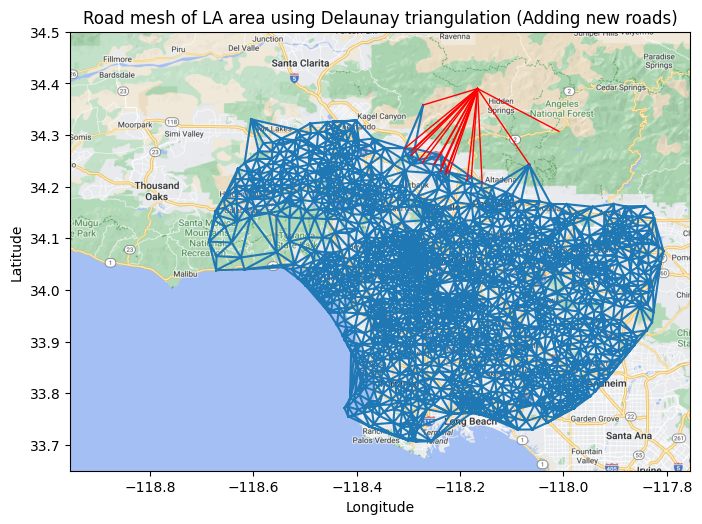

In [ ]:
for distance, v, s in extra_d_topk:
    g_del_prune.add_edge(v, s)

Bound = (-118.955, -117.755, 33.65, 34.5)
ruh_m = plt.imread('/content/drive/My Drive/ECE 232E/la.jpg')

fig, ax = plt.subplots(figsize=(8, 7))
plt.triplot(lon, lat, new_delaunay_out_desimplices)
ax.set_title('Road mesh of LA area using Delaunay triangulation (Adding new roads)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.set_xlim(Bound[0], Bound[1])
ax.set_ylim(Bound[2], Bound[3])
ax.imshow(ruh_m, zorder=0, extent=Bound, aspect='equal')

# Plot the added edges in a different color
for edge in extra_d_topk:
    v, s = edge[1], edge[2]
    x = [lon[v], lon[s]]
    y = [lat[v], lat[s]]
    ax.plot(x, y, color='red', linewidth=1)

plt.show()


time dynamic

In [ ]:
g_del_prune = igraph.Graph()
g_del_prune.add_vertices(len(delaunay_out.points))
nodes = g_del_prune.vs()
for i, node in enumerate(nodes):
    node['latitude'] = lat[i]
    node['longitude'] = lon[i]

threshold = (19.2 / 250)

duplicate_remove = set()
edge_cut = set()

def calculate_distance(node1, node2):
    return np.sqrt((node1['latitude'] - node2['latitude'])**2 + (node1['longitude'] - node2['longitude'])**2)

for simplex in delaunay_out.simplices:
    a = tuple(sorted((simplex[0], simplex[1])))
    b = tuple(sorted((simplex[0], simplex[2])))
    c = tuple(sorted((simplex[1], simplex[2])))

    if a not in duplicate_remove:
        duplicate_remove.add(a)
        a_dist_check = calculate_distance(nodes[a[0]], nodes[a[1]])
        if a_dist_check < threshold:
            g_del_prune.add_edges([a])
        else:
            edge_cut.add(a)

    if b not in duplicate_remove:
        duplicate_remove.add(b)
        b_dist_check = calculate_distance(nodes[b[0]], nodes[b[1]])
        if b_dist_check < threshold:
            g_del_prune.add_edges([b])
        else:
            edge_cut.add(b)

    if c not in duplicate_remove:
        duplicate_remove.add(c)
        c_dist_check = calculate_distance(nodes[c[0]], nodes[c[1]])
        if c_dist_check < threshold:
            g_del_prune.add_edges([c])
        else:
            edge_cut.add(c)

edge_cut_list = list(edge_cut)
simplices_list = []

for simplex in delaunay_out.simplices:
    for edge in edge_cut_list:
        if edge[0] in simplex and edge[1] in simplex:
            simplices_list.append(list(simplex))

new_delaunay_out_desimplices = [simplex for simplex in delaunay_out.simplices if list(simplex) not in simplices_list]


In [ ]:
weighted_extra_distances = [
    (extra_distance*random.randint(1, 1000), i, j)
    for extra_distance, i, j in tqdm(extra_d)
]
weighted_extra_distances_topk = sorted(weighted_extra_distances, reverse=True)[:k]
print("Top 20 pairs with highest weighted extra distance: (distance, v, s)")
print(weighted_extra_distances_topk)
display_edge_coordinates(weighted_extra_distances_topk)


  0%|          | 0/3686970 [00:00<?, ?it/s]

Top 20 pairs with highest weighted extra distance: (distance, v, s)
[(999999713.2770586, 732, 2470), (999999604.2867333, 2088, 2470), (999999494.3135784, 2456, 2470), (998999732.3167415, 1068, 2470), (998999520.8134015, 475, 2470), (998999426.1490811, 613, 2470), (996999765.3542614, 349, 2470), (996999674.5900912, 1115, 2470), (996999586.6527913, 1859, 2470), (995999631.2829156, 1987, 2470), (994999715.5134038, 1922, 2470), (994999430.9516109, 2470, 2581), (993999741.1062399, 844, 2470), (993999518.07355, 1967, 2470), (993999475.1049184, 334, 2470), (992999620.9151173, 1387, 2470), (992999555.6696391, 1007, 2470), (992999399.8755959, 658, 2470), (991999509.1179026, 408, 2470), (991999497.4914317, 256, 2470)]

edge 1: (-118.44574180681819, 34.325703420454545) - (-118.16620295644891, 34.38948489307649)

edge 2: (-117.93646313636363, 34.067291465909086) - (-118.16620295644891, 34.38948489307649)

edge 3: (-118.48561034042555, 33.99744193617021) - (-118.16620295644891, 34.38948489307649)



In [ ]:
cur_graph = g_del_prune.copy()
for distance, x, y in tqdm(weighted_extra_distances_topk):
    cur_graph.add_edge(x, y)

wed_new = sort_additional_distances(cur_graph)

print("The highest extra distance after adding new edges: (distance, v, s)")
print(wed_new[0])

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/8080 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

The highest extra distance after adding new edges: (distance, v, s)
(999999.9139368199, 2472, 2474)


In [ ]:
for distance, v, s in weighted_extra_distances_topk:
    g_del_prune.add_edge(v, s)

Bound = (-118.955, -117.755, 33.65, 34.5)
ruh_m = plt.imread('/content/drive/My Drive/ECE 232E/la.jpg')

fig, ax = plt.subplots(figsize=(8, 7))
plt.triplot(lon, lat, new_delaunay_out_desimplices)
ax.set_title('Road mesh of LA area using Delaunay triangulation (Adding new roads with wighted frequncy)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.set_xlim(Bound[0], Bound[1])
ax.set_ylim(Bound[2], Bound[3])
ax.imshow(ruh_m, zorder=0, extent=Bound, aspect='equal')

# Plot the added edges in a different color
for edge in weighted_extra_distances_topk:
    v, s = edge[1], edge[2]
    x = [lon[v], lon[s]]
    y = [lat[v], lat[s]]
    ax.plot(x, y, color='red', linewidth=1)

plt.show()